In [1]:
import json
import os
import re
from collections import Counter
from tqdm import tqdm
import numpy as np

import fitz  # from PyMuPDF

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Liberation Serif"

In [3]:
import spacy
nlp = spacy.load("en_core_web_sm")

## Split papers and extract text

In [4]:
def extract_text(pdffile):
    text = ''
    with fitz.open(pdffile) as doc:
        for page in doc:
            text += page.get_text() + ' '
    return text

In [5]:
def write(file, contents):
    with open(file, "w") as fout:
        print(contents, file=fout)


def extract_papers(file, output_folder, start_no=0):
    os.makedirs(output_folder, exist_ok=True)
    
    with fitz.open(file) as doc:
        current_paper = None
        paper_no = start_no

        for page in doc:
            text = page.get_text()
            if re.search(r"\nAbstract\s*\n", text):  # contains "Abstract"
                if current_paper is not None:
                    write(f"{output_folder}/{paper_no}", current_paper)
                    paper_no += 1
                current_paper = text + ' '
            elif current_paper is not None:
                current_paper += text + ' '
    
    write(f"{output_folder}/{paper_no}", current_paper)
    return paper_no


def extract_all_papers():
    for venue in ["acl", "emnlp"]:
        for year in range(2005, 2022):
            if os.path.exists(f"../data/{venue}/{year}.pdf"):
                n_papers = extract_papers(f"../data/{venue}/{year}.pdf", f"../data/extracted_text/{venue}/{year}")
                print(venue, year, n_papers)
            else:  # ACL short/long are separate in several years, see download.sh
                n_papers = extract_papers(f"../data/{venue}/{year}-long.pdf", f"../data/extracted_text/{venue}/{year}")
                n_papers = extract_papers(f"../data/{venue}/{year}-short.pdf", f"../data/extracted_text/{venue}/{year}", start_no=n_papers)
                print(venue, year, n_papers)

In [6]:
extract_all_papers()

acl 2005 76
acl 2006 76
acl 2007 130
acl 2008 118
acl 2009 152
acl 2010 227
acl 2011 290
acl 2012 186
acl 2013 332
acl 2014 290
acl 2015 319
acl 2016 331
acl 2017 303
acl 2018 381
acl 2019 661
acl 2020 781
acl 2021 713
emnlp 2005 125
emnlp 2006 70
emnlp 2007 129
emnlp 2008 113
emnlp 2009 162
emnlp 2010 123
emnlp 2011 147
emnlp 2012 140
emnlp 2013 204
emnlp 2014 224
emnlp 2015 310
emnlp 2016 263
emnlp 2017 324
emnlp 2018 549
emnlp 2019 681
emnlp 2020 753
emnlp 2021 850


## Read and parse acks

In [7]:
def find_next_header(text, start):
    i = text.find("References\n", start)
    if i == -1:
        i = text.find("Ethical Considerations\n", start)
    if i == -1:
        i = text.find("Broader Impact\n", start)
    return i

In [8]:
def clean_ethics(text):
    if text is None:
        return text
    headers = ["Ethical Considerations", "Ethical Consideration", "Ethical considerations", "Broader Impact", "Ethics and Broader Impact", "Ethics Statement"]
    for h in headers:
        i = text.find(h)
        if i > -1:
            return text[:i]
    return text

In [11]:
ACK_STRINGS = set(["Acknowledgments", "Acknowledgements", "Acknowledgement", "Acknowledgment"])

def extract_ack(text):
    header = None
    section = None
    for ack in ACK_STRINGS:
        idx = text.find(ack + '\n')
        if idx == -1:
            continue
        header = ack
        start = idx + len(ack) + 1
        end = find_next_header(text, start)
        section = text[start:end]

    parse = None
    if header is not None:
        section = section.replace("-\n", "")  # remove hyphens
        section = section.replace("\n", " ")  # replace linebreaks
        section = clean_ethics(section)
        
        section = re.sub(r"(.+) \d+  ", r"\1", section)  # remove page number
        
        section = section.strip()
        
    return (header, section)

In [12]:
def read_acks():
    acks = {}
    for year in range(2005, 2022):
        acks[year] = []
        for venue in ["acl", "emnlp"]:
            for file in os.listdir(f"../data/extracted_text/{venue}/{year}"):
                if not os.path.isfile(f"../data/extracted_text/{venue}/{year}/{file}"):
                    continue
                with open(f"../data/extracted_text/{venue}/{year}/{file}") as fin:
                    text = fin.read()
                    header, section = extract_ack(text)
                    acks[year].append((venue, header, section))
    return acks

In [13]:
acks = read_acks()

In [14]:
def save_dataset(acks):
    with open("../data/acks.jsonl", "w") as fout:
        for year in acks:
                for venue, header, section in acks[year]:
                    if header is not None:
                        d = {"year": year, "venue": venue, "header": header, "text": section}
                        print(json.dumps(d, ensure_ascii=False), file=fout)

In [15]:
save_dataset(acks)

In [17]:
def read_dataset():
    data = []
    with open("../data/acks.clean.jsonl") as fout:
        for line in fout:
            d = json.loads(line)
            data.append(d)
    return data

data = read_dataset()

In [19]:
for i, d in enumerate(data):
    text = d['text']
    if len(text) > 1000 or re.findall(r"\d+  ", text):
        print(i + 1)
        
# 286 is a valid ack, tons of people

11
286
1078
1343
1468
1743
2145
2285
2589
2718
2952
3159
3330
3346
3395
3529
3574
3707
4161
4452
4524
4551
4907
5253
5847
5853
5885
5944
5951
6025
6058
6178
6221
6280
7113
7121
7240
7346
7380
7434
7578
7796
7818


## How many papers total?

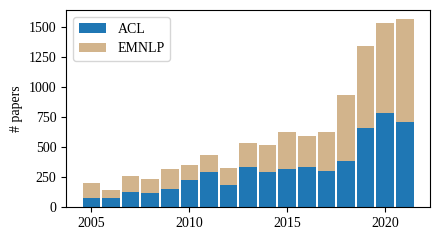

In [20]:
def count2(acks, venue):
    return sum(x[0] == venue for x in acks)

def plot_counts2(acks):
    years = list(range(2005,2022))
    acl = [count2(acks[year], 'acl') for year in years]
    emnlp = [count2(acks[year], 'emnlp') for year in years]
    
    fig, ax = plt.subplots(figsize=(4.5,2.5))
    
    ax.bar(years, acl, 0.9, label='ACL')
    ax.bar(years, emnlp, 0.9, bottom=acl, label='EMNLP', color='tan')
    
    ax.legend()
    
    plt.ylabel("# papers")
    plt.xticks(range(2005, 2022, 5))
    
    plt.tight_layout()
    plt.savefig("figures/paper-counts.pdf")
    plt.show()

plot_counts2(acks)

In [21]:
sum(x['year'] == 2005 and x['venue'] == 'emnlp' for x in data)

56

## Percentage of papers with acknowledgments

[46.30541871921182, 48.648648648648646, 48.65900383141762, 60.08583690987125, 49.68354430379747, 64.48863636363636, 69.70387243735763, 69.51219512195122, 70.817843866171, 72.86821705426357, 73.53407290015848, 79.53020134228188, 77.74244833068363, 76.931330472103, 78.7202380952381, 81.8359375, 80.19169329073482]


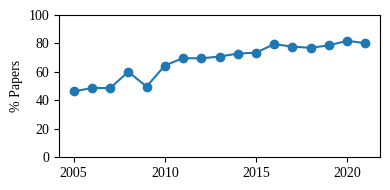

In [22]:
def count_not_none(arr):
    c = 0
    for venue, header, section in arr:
        if header is not None:
            c += 1
    return c

def plot_proportion(acks):
    years = sorted(acks.keys())
    props = [count_not_none(acks[year]) * 100 / len(acks[year]) for year in years]
    
    print(props)
    plt.figure(figsize=(4,2))
    plt.plot(years, props, 'o-')
    plt.ylim([0.0, 100.0])
    plt.ylabel("% Papers")
    
    plt.tight_layout()
    plt.savefig("has_acks.pdf")
    plt.show()
    
plot_proportion(acks)
    

## Length of Acknowledgments

In [23]:
len(data)

7838

mean: 305.1980096963511
std: 172.55832030867379
min: 35
max: 2408


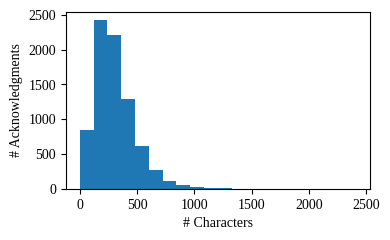

In [25]:
def plot_ack_lengths():
    lengths = []
    for d in data:
        lengths.append(len(d['text']))
        
    print('mean:', np.mean(lengths))
    print('std:', np.std(lengths))
    print('min:', min(l for l in lengths if l != 0))
    print('max:', max(lengths))

    plt.figure(figsize=(4,2.5))
    plt.hist(lengths, bins=20)
    plt.xlabel("# Characters")
    plt.ylabel("# Acknowledgments")
    plt.tight_layout()

    plt.savefig("figures/lengths.pdf")
    plt.show()


plot_ack_lengths()

## Who is acknowledged?

In [26]:
parses = [nlp(d['text']) for d in data]

In [27]:
def add_children(tokens):
    for i, t in enumerate(tokens):
        tokens[i]['children'] = set()
    for i, t in enumerate(tokens):
        if t['dep'] != 'ROOT':
            head = t['head']
            tokens[head]['children'].add(t['id'])

In [28]:
def flood_children(tokens, i):
    seen = set()
    s = [i]
    while s != []:
        id = s.pop()
        seen.add(id)
        for ch in tokens[id]['children']:
            s.append(ch)
    return seen

In [8]:
def all_children(tok):
    seen = set()
    s = [tok]
    while s != []:
        t = s.pop()
        seen.add(t)
        for ch in t.children:
            s.append(ch)
    return sorted([t.i for t in seen])

In [29]:
def make_ignore_set(parse):
    ignore = set()

    # sentences about corresponding author
    for s in parse.sents:
        if 'corresponding author' in s.text or 'contact author' in s.text:
            for id in range(s.start, s.end):
                ignore.add(id)
    
    tokens = parse.to_json()['tokens']
    add_children(tokens)
    
    # passive subject of "is supported by"
    support_verbs = set(['support', 'fund'])
    for t in tokens:
        if t['lemma'] in support_verbs:
            for cid in t['children']:
                child = tokens[cid]
                if child['dep'] == 'nsubjpass':
                    for id in flood_children(tokens, child['id']):
                        ignore.add(id)

    # subject of "acknowledge"
    thanking_verbs = set(['thank', 'acknowledge', 'appreciate', 'enjoy'])
    for t in tokens:
        if t['lemma'] in thanking_verbs:
            for cid in t['children']:
                child = tokens[cid]
                if child['dep'] == 'nsubj':
                    for id in flood_children(tokens, child['id']):
                        ignore.add(id)
    
    return ignore

In [31]:
abbreviations = {
    "National Science Foundation": "NSF",
    "Defense Advanced Research Projects Agency": "DARPA",
    "The U.S. Government": "U.S. Government",
    "European Research Council": "ERC",
    "Intelligence Advanced Research Projects Activity": "IARPA",
    "Natural Science Foundation of China": "NSFC",
    "National Natural Science Foundation of China": "NSFC",
    "National Key Research and Development Program of China": "NKP",
    "National Key R&D Program of China": "NKP",
    "Army Research Office": "ARO",
    "Office of Naval Research": "ONR",
    "Air Force Research Laboratory": "AFRL",
    "Engineering and Physical Sciences Research Council": "EPSRC"
}

def abbreviate(name):
    return abbreviations.get(name, name)

In [32]:
def count_govt_acks(data, parses):
    count_govt = Counter()
    sorted_abbrs = sorted(abbreviations, key=lambda x: -len(x))
    print(sorted_abbrs)

    for d, p in zip(data, parses):
        seen = set()

        text = d['text']
        for name in sorted_abbrs:
            text = text.replace(name, abbreviations[name])


        for abbr in abbreviations.values():
            myregex = r"\W" + re.escape(abbr) + r"\W"
            if re.findall(myregex, text):
                seen.add(abbr)
                count_govt[abbr] += 1

        for e in p.ents:
            if e.label_ == 'ORG':
                abbr = re.sub(r"^[Tt]he ", "", e.text)
                abbr = abbreviate(abbr)

                if abbr not in seen:
                    seen.add(abbr)
                    count_govt[abbr] += 1
    return count_govt

count_govt = count_govt_acks(data, parses)

['National Key Research and Development Program of China', 'Engineering and Physical Sciences Research Council', 'Intelligence Advanced Research Projects Activity', 'National Natural Science Foundation of China', 'Defense Advanced Research Projects Agency', 'Natural Science Foundation of China', 'National Key R&D Program of China', 'Air Force Research Laboratory', 'National Science Foundation', 'European Research Council', 'Office of Naval Research', 'Army Research Office', 'The U.S. Government']


In [33]:
for k, v in count_govt.most_common(20):
    print(k, '&', v, '\\\\')

NSFC & 2408 \\
NSF & 1653 \\
DARPA & 920 \\
NKP & 762 \\
U.S. Government & 357 \\
ERC & 348 \\
EPSRC & 219 \\
AFRL & 161 \\
IARPA & 158 \\
ARO & 154 \\
Google & 149 \\
ONR & 147 \\
German Research Foundation & 138 \\
DFG & 128 \\
European Union’s & 118 \\
EU & 98 \\
National Research Foundation & 96 \\
Fundamental Research Funds & 96 \\
ACL & 92 \\
NSERC & 89 \\


In [35]:
# govt funders by year

govt_top10 = set(["NSFC", "NSF", "DARPA", "NKP", "ERC", "EPSRC", "AFRL", "IARPA", "ARO", "ONR"])

def govt_by_year(data, parses):
    count_govt_by_year = {}
    sorted_abbrs = sorted(abbreviations, key=lambda x: -len(x))
    
    
    def add(year, org):
        if org not in count_govt_by_year:
            count_govt_by_year[org] = Counter()
        count_govt_by_year[org][year] += 1
        
        
    for d, p in zip(data, parses):
        seen = set()

        text = d['text']
        for name in sorted_abbrs:
            text = text.replace(name, abbreviations[name])

        for abbr in abbreviations.values():
            myregex = r"\W" + re.escape(abbr) + r"\W"
            if re.findall(myregex, text):
                if abbr in govt_top10:
                    seen.add(abbr)
                    add(d['year'], abbr)

        for e in p.ents:
            if e.label_ == 'ORG':
                abbr = re.sub(r"^[Tt]he ", "", e.text)
                abbr = abbreviate(abbr)

                if abbr not in seen and abbr in govt_top10:
                    seen.add(abbr)
                    add(d['year'], abbr)
    return count_govt_by_year

count_govt_year = govt_by_year(data, parses)

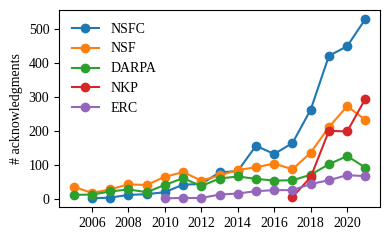

In [37]:
def plot_govt_by_year(gov):
    fig, ax = plt.subplots(figsize=(4,2.5))
    
    years = range(2005, 2022)
    for org in sorted(govt_top10, key=lambda org: -sum(gov[org].values()))[:5]:
        counts = [gov[org][y] for y in years]
        
        first_nonzero = 0
        for i in range(len(counts)):
            if counts[i] > 0:
                first_nonzero = i
                break
        
        x = years[first_nonzero:]
        y = counts[first_nonzero:]
        ax.plot(x, y, 'o-', label=org, )
    
    ax.legend(frameon=False)
    
    plt.ylabel("# acknowledgments")
    plt.xticks(range(2006, 2022, 2))
    plt.tight_layout()
    plt.savefig("figures/govt-by-year.pdf")
    plt.show()

plot_govt_by_year(count_govt_year)

In [69]:
def count_grants(data, parses):
    grant_list = set(['678254', 'CwC', 'AIDA', 'MCS'])
    counts = {}
    for d, p in zip(data, parses):
        ignore = make_ignore_set(p)
        ents = p.ents

        for e in ents:
            if any(i in ignore for i in range(e.start, e.end)):
                continue

            text = re.sub(r"^the ", "", e.text)
            text = re.sub(r"([Ff]ocused)? [Rr]esearch [Aa]ward", "", text)
            text = abbreviate(text)
            
            for grant in grant_list:
                if grant in text:
                    if grant not in counts:
                        counts[grant] = Counter()
                    counts[grant][d['year']] += 1
    return counts

grant_counts = count_grants(data, parses)

In [70]:
grant_counts

{'CwC': Counter({2016: 3, 2017: 4, 2018: 6, 2019: 8, 2020: 11, 2021: 2}),
 '678254': Counter({2017: 2, 2018: 3, 2019: 11, 2020: 7, 2021: 7}),
 'AIDA': Counter({2018: 8, 2019: 13, 2020: 10, 2021: 3}),
 'MCS': Counter({2019: 8, 2020: 16, 2021: 20})}

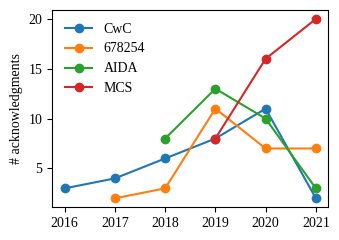

In [73]:
def plot_grants(grant_counts):
    fig = plt.figure(figsize=(3.5,2.5))
    years = range(2005, 2022)
    grants = grant_counts.keys()
    
    for g in grants:
        counts = [grant_counts[g][year] for year in years]
        
        first_nonzero = 0
        for i in range(len(counts)):
            if counts[i] > 0:
                first_nonzero = i
                break
        
        x = years[first_nonzero:]
        y = counts[first_nonzero:]
        plt.plot(x, y, 'o-', label=g)
        
        # plt.plot(years, counts, 'o-', label=g)
    
    plt.legend(frameon=False)
    
    plt.ylabel("# acknowledgments")
    plt.tight_layout()
    plt.savefig("figures/grants.pdf")
    plt.show()
    
plot_grants(grant_counts)

In [42]:
count_reviewers = 0
for d in data:
    if 'reviewer' in d['text'] or 'reviewers' in d['text']:
        count_reviewers += 1

In [43]:
count_reviewers

4065

In [44]:
count_reviewers / len(data)

0.5186272008165348

## Industry acks

In [45]:
count_industry = Counter()
companies = set(["google", "facebook", "microsoft", "ebay", "amazon", "adobe", "apple", "nvidia", "bloomberg", "salesforce", "ericsson", "intel", "futurewei", "vmware"])
for d in data:
    for c in companies:
        if c in d['text'].lower():
            count_industry[c] += 1

In [46]:
for k, v in count_industry.most_common():
    print(k, '&', v, '\\\\')

google & 576 \\
intel & 536 \\
nvidia & 224 \\
microsoft & 182 \\
amazon & 161 \\
facebook & 120 \\
bloomberg & 77 \\
adobe & 34 \\
salesforce & 28 \\
ebay & 19 \\
apple & 18 \\
ericsson & 5 \\
vmware & 5 \\
futurewei & 1 \\


In [47]:
def industry_by_year(data):
    count_industry = {}
    companies = set(["google", "facebook", "microsoft", "ebay", "amazon", "adobe", "apple", "nvidia", "bloomberg", "salesforce", "ericsson", "intel", "futurewei", "vmware"])
    for d in data:
        for c in companies:
            if c in d['text'].lower():
                if c not in count_industry:
                    count_industry[c] = Counter()
                count_industry[c][d['year']] += 1
    return count_industry

count_industry_year = industry_by_year(data)

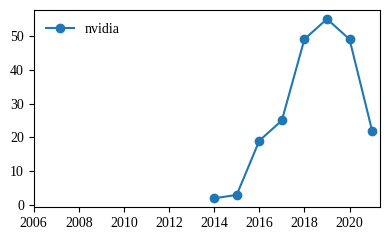

In [48]:
def plot_industry_by_year(gov):
    fig, ax = plt.subplots(figsize=(4,2.5))
    
    years = range(2005, 2022)
    for org in sorted(companies, key=lambda org: -sum(gov[org].values()))[:5]:
        if org != "nvidia":
            continue
        counts = [gov[org][y] for y in years]
        
        first_nonzero = 0
        for i in range(len(counts)):
            if counts[i] > 0:
                first_nonzero = i
                break
        
        x = years[first_nonzero:]
        y = counts[first_nonzero:]
        ax.plot(x, y, 'o-', label=org, )
    
    ax.legend(frameon=False)
    
    # plt.ylabel("# acknowledgments")
    plt.xticks(range(2006, 2022, 2))
    plt.tight_layout()
    plt.savefig("figures/industry-by-year.pdf")
    plt.show()

plot_industry_by_year(count_industry_year)

## How do people spell acknowledgement anyway?

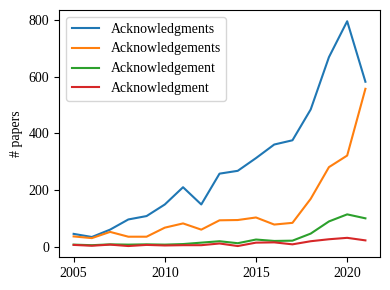

In [54]:
def plot_spelling2(data):
    all_counts = {ack: [0 for i in range(2005, 2022)] for ack in ACK_STRINGS}

    for ack in data:
        all_counts[ack["header"]][ack["year"] - 2005] += 1
    
    plt.figure(figsize=(4,3))
    
    years = sorted(acks.keys())
    
    for ack in ["Acknowledgments", "Acknowledgements", "Acknowledgement", "Acknowledgment"]:
        plt.plot(years, all_counts[ack], '-', label=ack)
    
    plt.ylabel("# papers")
    
    plt.legend()
    
    plt.tight_layout()
    plt.savefig("figures/spelling.pdf")
    plt.show()
    

plot_spelling2(data)

## Who are acknowledged?

In [56]:
entities = Counter()
for p in parses:
    for e in p.ents:
        text = e.text
        text = re.sub(r"^[Tt]he ", "", text)
        entities[text] += 1

In [57]:
entities.most_common(10)

[('NSF', 1111),
 ('National Natural Science Foundation of China', 913),
 ('DARPA', 859),
 ('U.S. Government', 576),
 ('National Science Foundation', 560),
 ('three', 392),
 ('China', 223),
 ('Defense Advanced Research Projects Agency', 208),
 ('National Key Research and Development Program of China', 196),
 ('EPSRC', 195)]

In [58]:
people = Counter()
for p in parses:
    for e in p.ents:
        if e.label_ == "PERSON":
            text = e.text
            text = re.sub(r"^[Tt]he ", "", text)
            people[text] += 1

In [59]:
people.most_common(10)

[('Grant No', 148),
 ('DEFT', 53),
 ('Yue Zhang', 49),
 ('KAKENHI', 49),
 ('Luke Zettlemoyer', 46),
 ('Michael Collins', 41),
 ('Grant Nos', 41),
 ('Yoav Goldberg', 31),
 ('Xu Sun', 30),
 ('GU', 28)]

## What are they acknowledged for?

In [60]:
def thankful_for(parses):
    counts = Counter()
    for p in parses:
        for tok in p:
            if tok.lemma_ == 'for':
                for c in tok.children:
                    counts[c.lemma_] += 1
    return counts

In [61]:
thanks = thankful_for(parses)

In [62]:
for k, v in thanks.most_common(20):
    print(k, '&', v, '\\\\')

comment & 2866 \\
feedback & 1065 \\
discussion & 926 \\
help & 579 \\
suggestion & 503 \\
provide & 492 \\
support & 289 \\
purpose & 248 \\
share & 149 \\
Research & 135 \\
advice & 120 \\
Universities & 101 \\
assistance & 93 \\
work & 87 \\
and & 73 \\
Intelligence & 70 \\
research & 64 \\
contribution & 63 \\
Science & 61 \\
input & 57 \\
